In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
crime_time_series = pd.read_csv("crime_time_series_2.csv")
print(crime_time_series.columns)
print(crime_time_series.shape[0])

Index(['census_block', 'date', 'dow_sin', 'dow_cos', 'day_sin', 'day_cos',
       'month_sin', 'month_cos', 'temp_max', 'temp_min', 'temp_range',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'week_precipitation_interaction', 'daylight_precipitation_interaction',
       'block_week_interaction', 'block_temp_max_interaction',
       'temp_range_precipitation_interaction', 'is_holiday', 'week_of_year',
       'Crime_Count_W', 'Crime_Count_W_lag1w', 'Crime_Count_W_lag4w',
       'Crime_Count_W_lag12w', 'Crime_Count_W_lag24w', 'Crime_Count_W_lag52w',
       'Crime_Count_W_rolling2', 'Crime_Count_W_rolling3',
       'Crime_Count_W_rolling4', 'Crime_Count_W_rolling8',
       'Crime_Count_W_rolling15', 'week_rolling2_interaction',
       'temp_rolling2_interaction', 'precip_rolling2_interaction',
       'week_rolling3_interaction', 'temp_rolling3_interaction',
       'precip_rolling3_interaction', 'week_rolling4_interaction',
       'temp_rolling4_interaction'

In [3]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def time_series_cross_validation(model, X, y, k=5):
    tscv = TimeSeriesSplit(n_splits=k)
    fold_metrics = []
    feature_importances_by_fold = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = []
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))
        
        # Save feature importances for this fold
        feature_importances = model['model'].feature_importances_
        feature_importances_by_fold.append(feature_importances)

        # Plot residuals
        residuals = np.array(y_test) - np.array(y_pred)
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(residuals)), residuals, alpha=0.5, label=f"Fold {fold + 1}")
        plt.axhline(0, color='red', linestyle='--', linewidth=1)
        plt.title(f'Residuals for Fold {fold + 1}')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Residual (Actual - Predicted)')
        plt.legend()
        plt.show()

    # Plot overall residuals
    plt.figure(figsize=(12, 6))
    plt.plot(all_y_test, label='Actual')
    plt.plot(all_y_pred, label='Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.xlabel('Time (Ordered Test Samples)')
    plt.ylabel('Values')
    plt.show()

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [4]:
features = [
    "dow_cos", "dow_sin", "precipitation_hours",
    "Crime_Count_W_rolling15", "Crime_Count_W_rolling8", "Crime_Count_W_rolling4",
    "day_cos", "Crime_Count_W_rolling3", "Crime_Count_W_rolling2",
    "temp_rolling15_interaction", "temp_rolling4_interaction", "temp_rolling3_interaction",
    "temp_rolling2_interaction", "precip_rolling2_interaction", "Crime_Count_W_lag1w",
    "Crime_Count_W_lag4w", "day_sin", "daylight_lag1_interaction", "precip_rolling3_interaction",
    "daylight_lag12_interaction", "daylight_lag4_interaction", "daylight_lag24_interaction",
    "Crime_Count_W_lag52w", "precip_rolling4_interaction", "Crime_Count_W_lag12w",
    "precipitation_sum", "Crime_Count_W_lag24w", "daylight_lag52_interaction",
    "temp_range", "precip_rolling15_interaction"
]

categorical_features = ['census_block']

X = crime_time_series[features + categorical_features]
y = crime_time_series['Crime_Count_W']

In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

# Define frequency encoding as a custom transformer
def frequency_encode(X, categorical_features):
    X_encoded = X.copy()
    for col in categorical_features:
        freq_map = X[col].value_counts(normalize=False).to_dict()
        X_encoded[col] = X[col].map(freq_map)
    return X_encoded

# Wrap the frequency encoding logic into a FunctionTransformer
frequency_encoder = FunctionTransformer(lambda X: frequency_encode(X, categorical_features), validate=False)

# Define the pipeline
pipeline = Pipeline([
    ('frequency_encoder', frequency_encoder),
    ('model', XGBRegressor(objective='count:poisson', eval_metric='rmse', random_state=42))
])

# Define parameter distributions for randomized search
param_grid = {
    'model__n_estimators': [100, 300, 350, 400, 500],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2]
}

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Implement GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    return_train_score=False
)

# Fit RandomizedSearchCV
grid_search.fit(X, y)

# Extract best parameters and score
print(f"Best MAE Score: {-grid_search.best_score_:.4f}")
print("Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
    
best_params = {key.replace('model__', ''): value for key, value in grid_search.best_params_.items()}

Fitting 5 folds for each of 10935 candidates, totalling 54675 fits



KeyboardInterrupt



In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.freq_maps = {}

    def fit(self, X, y=None):
        for col in self.categorical_features:
            freq_map = X[col].value_counts(normalize=True).to_dict()
            self.freq_maps[col] = freq_map
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_features:
            freq_map = self.freq_maps[col]
            X_encoded[col] = X[col].map(freq_map).fillna(0)
        return X_encoded

# Define the pipeline
pipeline = Pipeline([
    ('frequency_encoder', FrequencyEncoder(categorical_features)),
    ('model', XGBRegressor(objective='count:poisson', eval_metric='rmse', random_state=42))
])

# Define parameter distributions for randomized search
param_distributions = {
    'model__n_estimators': randint(50, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'model__subsample': uniform(0.6, 0.4),        # 0.6 to 1.0
    'model__colsample_bytree': uniform(0.6, 0.4), # 0.6 to 1.0
    'model__gamma': uniform(0, 1),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1.5)
}

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Implement RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # Adjust based on available resources
    scoring=scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=False
)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Extract best parameters and score
print(f"Best MAE Score: {-random_search.best_score_:.4f}")
print("Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Extract best pipeline
best_pipeline = random_search.best_estimator_

best_params = {key.replace('model__', ''): value for key, value in random_search.best_params_.items()}

# Save the best pipeline
joblib.dump(best_pipeline, 'crime_prediction_model.pkl')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score: 0.2871
Best Parameters:
  model__colsample_bytree: 0.8599094730571053
  model__gamma: 0.048058924197033726
  model__learning_rate: 0.19033768900236334
  model__max_depth: 6
  model__n_estimators: 339
  model__reg_alpha: 0.26089362334171395
  model__reg_lambda: 0.022956810435577124
  model__subsample: 0.9733745232317932


['crime_prediction_model.pkl']

Fold 1 Metrics:
  Mean Absolute Error (MAE): 0.33713985322861884
  Root Mean Squared Error (RMSE): 0.3990278616048368
  R² Score: 0.8204922284119612



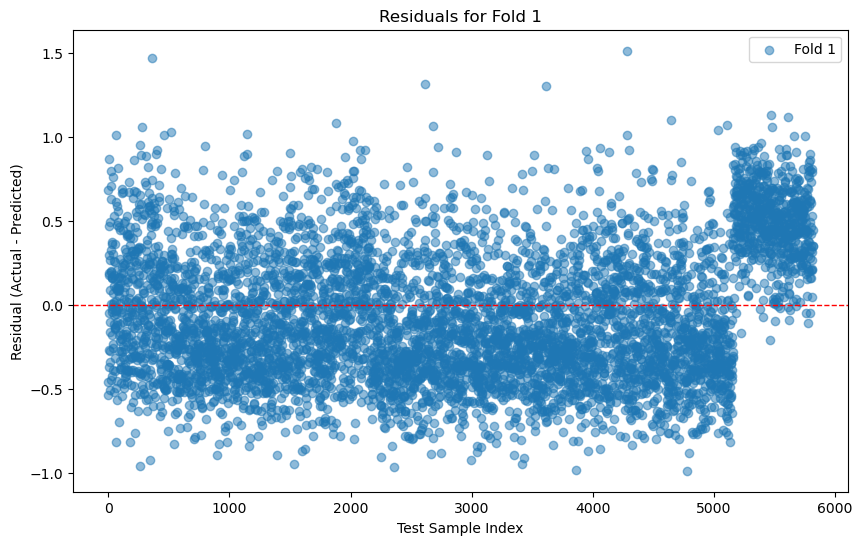

Fold 2 Metrics:
  Mean Absolute Error (MAE): 0.28956181705122813
  Root Mean Squared Error (RMSE): 0.37133714990066763
  R² Score: 0.7952516770204654



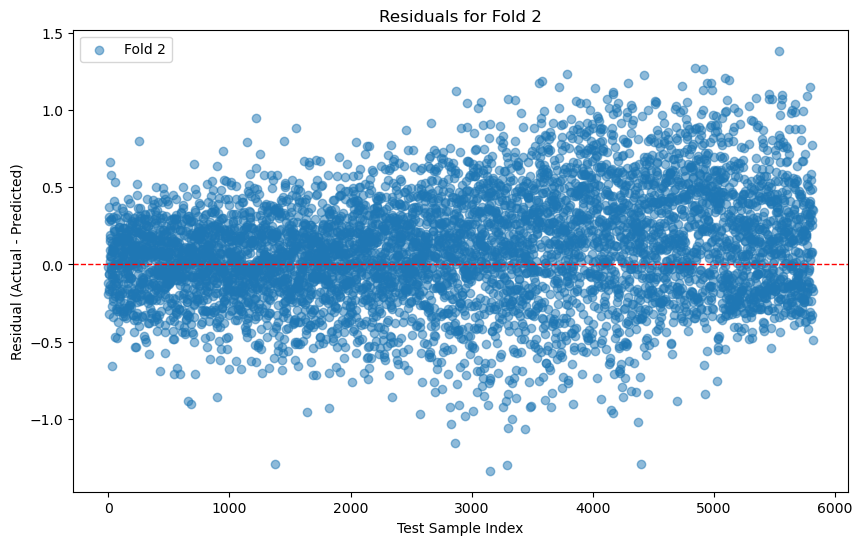

Fold 3 Metrics:
  Mean Absolute Error (MAE): 0.3072445906394752
  Root Mean Squared Error (RMSE): 0.3844018671423505
  R² Score: 0.838713943071024



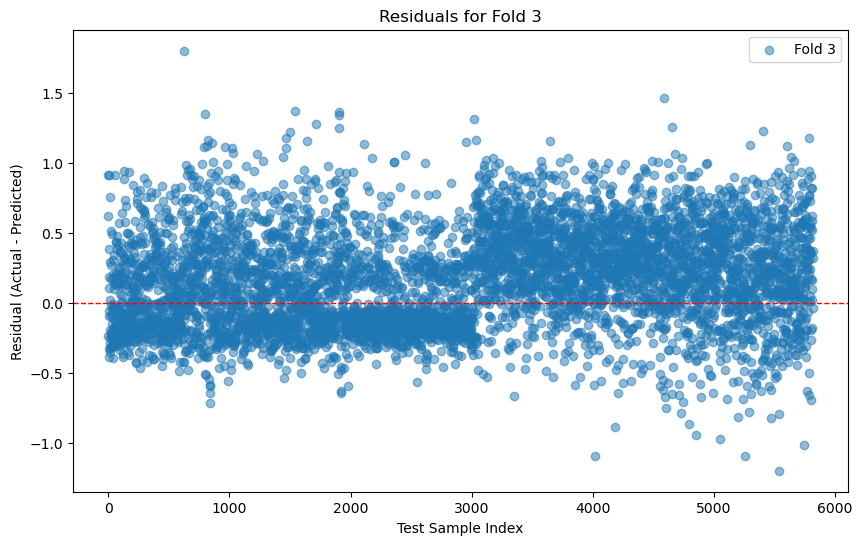

Fold 4 Metrics:
  Mean Absolute Error (MAE): 0.2567281891426026
  Root Mean Squared Error (RMSE): 0.3156187214212916
  R² Score: 0.7652756679155728



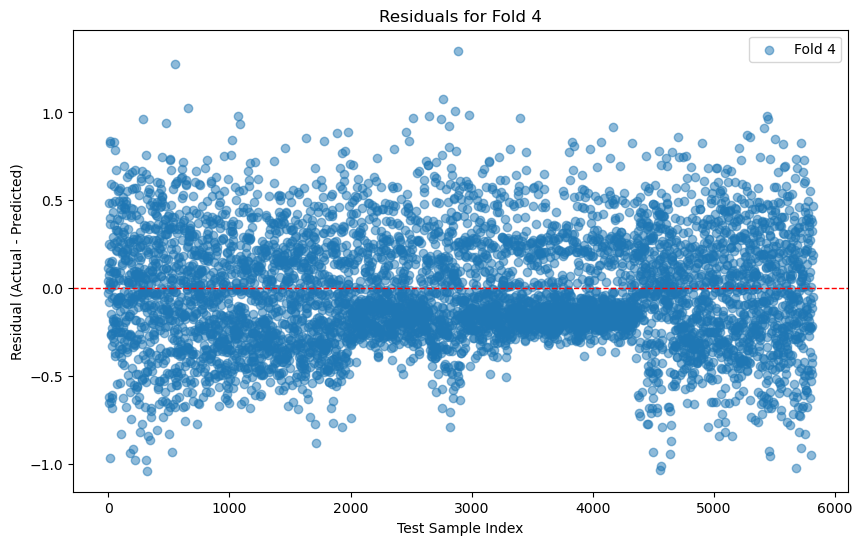

Fold 5 Metrics:
  Mean Absolute Error (MAE): 0.24507289619606745
  Root Mean Squared Error (RMSE): 0.3018756738995677
  R² Score: 0.7383619343282701



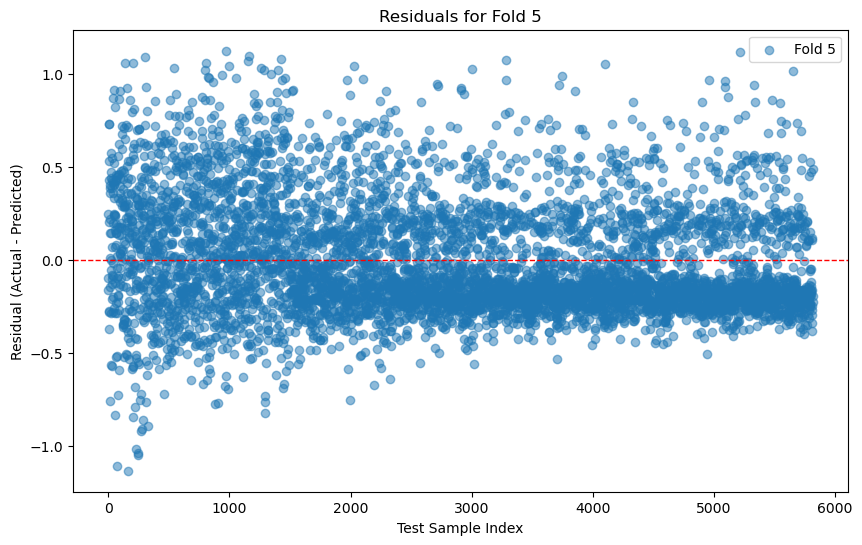

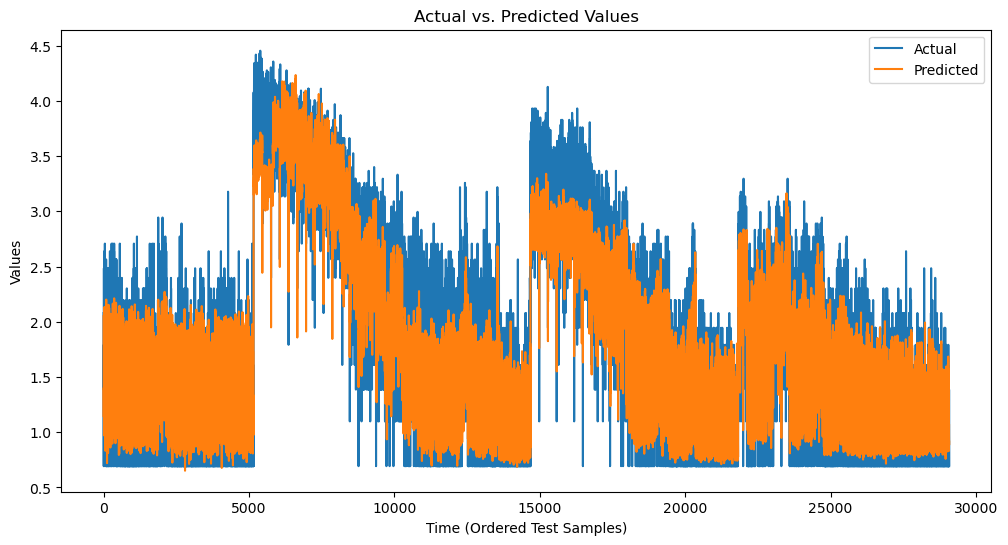

Average MAE across 5 folds: 0.28714946925159845
Average RMSE across 5 folds: 0.35445225479374287
Average R² Score across 5 folds: 0.7916190901494586


In [6]:
from xgboost import XGBRegressor


avg_mae, avg_rmse, avg_r2, metrics = time_series_cross_validation(best_pipeline, X, y)

In [7]:
future_data = pd.read_csv("future_data.csv")

features = [
    "dow_cos", "dow_sin", "precipitation_hours",
    "Crime_Count_W_rolling15", "Crime_Count_W_rolling8", "Crime_Count_W_rolling4",
    "day_cos", "Crime_Count_W_rolling3", "Crime_Count_W_rolling2",
    "temp_rolling15_interaction", "temp_rolling4_interaction", "temp_rolling3_interaction",
    "temp_rolling2_interaction", "precip_rolling2_interaction", "Crime_Count_W_lag1w",
    "Crime_Count_W_lag4w", "day_sin", "daylight_lag1_interaction", "precip_rolling3_interaction",
    "daylight_lag12_interaction", "daylight_lag4_interaction", "daylight_lag24_interaction",
    "Crime_Count_W_lag52w", "precip_rolling4_interaction", "Crime_Count_W_lag12w",
    "precipitation_sum", "Crime_Count_W_lag24w", "daylight_lag52_interaction",
    "temp_range", "precip_rolling15_interaction"
]

categorical_features = ['census_block']

# Using the same features as in training
X_future = future_data[features + categorical_features]

In [8]:
# Load the model
best_pipeline = joblib.load('crime_prediction_model.pkl')

# Predict future crime counts
y_future_pred = best_pipeline.predict(X_future)

# Reverse log transformation applied during preprocessing
y_future_pred = np.expm1(y_future_pred)

# Add predictions to your future data
future_data['Predicted_Crime_Count_W'] = y_future_pred

future_data[['census_block', 'date', 'Predicted_Crime_Count_W']].to_csv('future_data_preds.csv', index=False)

# Display predictions
print(future_data[['census_block', 'date', 'Predicted_Crime_Count_W']])

     census_block        date  Predicted_Crime_Count_W
0            1000  2024-10-13                 1.984734
1            1001  2024-10-13                 1.998308
2            1002  2024-10-13                 1.938887
3            1003  2024-10-13                 1.938887
4            1004  2024-10-13                 1.914062
..            ...         ...                      ...
176          6001  2024-10-13                 2.276945
177          6002  2024-10-13                 1.755134
178          6003  2024-10-13                 8.226205
179          6004  2024-10-13                 1.732205
180          6006  2024-10-13                 7.860405

[181 rows x 3 columns]


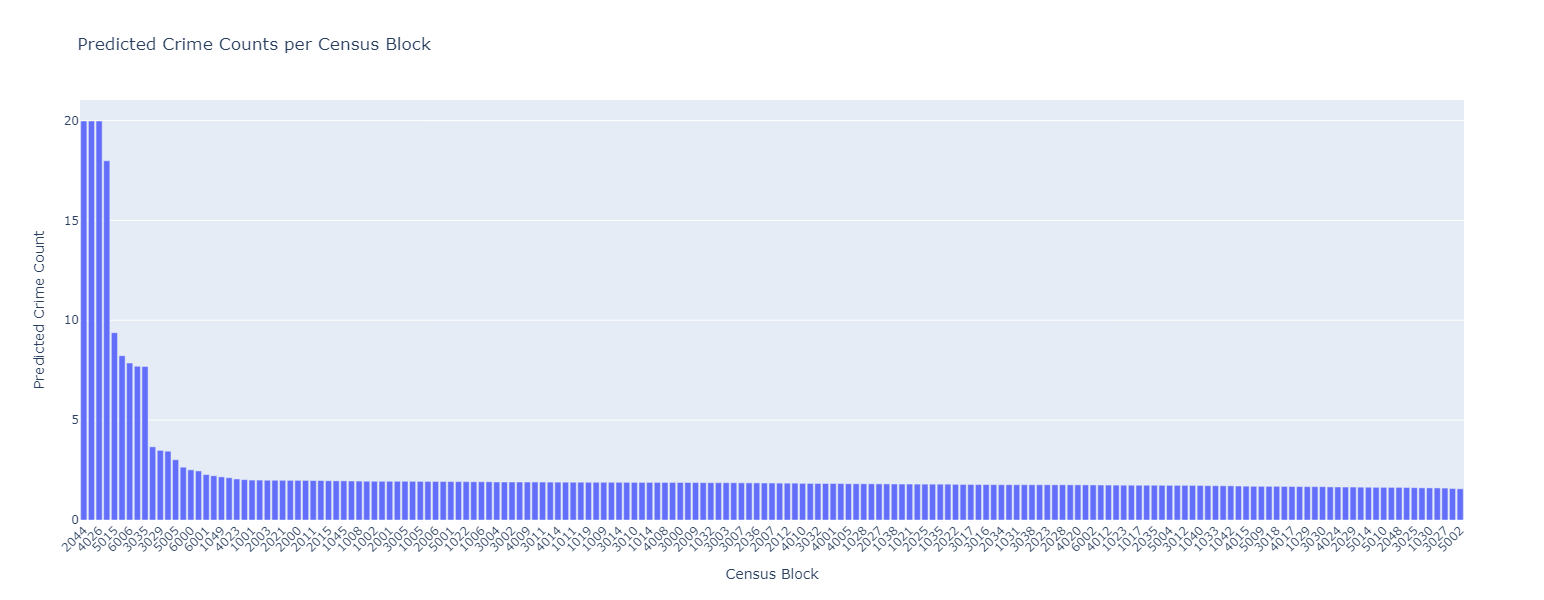

In [9]:
import plotly.express as px

future_data['census_block_str'] = future_data['census_block'].astype(str)

fig = px.bar(
    future_data,
    x='census_block_str',
    y='Predicted_Crime_Count_W',
    title='Predicted Crime Counts per Census Block',
    labels={'census_block_str': 'Census Block', 'Predicted_Crime_Count_W': 'Predicted Crime Count'},
    hover_data=['census_block', 'Predicted_Crime_Count_W']
)

fig.update_layout(
    xaxis_tickangle=-45,
    xaxis={'categoryorder':'total descending'},
    width=1000,
    height=600
)

fig.show()

In [10]:
# Get feature importances from the model
feature_importances = best_pipeline.named_steps['model'].feature_importances_

importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                         Feature  Importance
3        Crime_Count_W_rolling15    0.436579
4         Crime_Count_W_rolling8    0.302511
30                  census_block    0.139124
7         Crime_Count_W_rolling3    0.022046
0                        dow_cos    0.020307
1                        dow_sin    0.018198
27    daylight_lag52_interaction    0.005116
5         Crime_Count_W_rolling4    0.004494
2            precipitation_hours    0.004346
17     daylight_lag1_interaction    0.004062
25             precipitation_sum    0.003816
21    daylight_lag24_interaction    0.003662
11     temp_rolling3_interaction    0.002786
9     temp_rolling15_interaction    0.002473
6                        day_cos    0.002163
10     temp_rolling4_interaction    0.002103
28                    temp_range    0.002034
12     temp_rolling2_interaction    0.001900
22          Crime_Count_W_lag52w    0.001869
29  precip_rolling15_interaction    0.001825
8         Crime_Count_W_rolling2    0.001802
23   preci